In [1]:
import sys

sys.path.append("../../")


In [2]:
import pickle
from itertools import product
from pathlib import Path
from random import choices
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import seaborn as sns

from src.eval import (
    Episode,
    Study,
    number_of_better_final_beams,
    plot_beam_parameters_on_screen,
    plot_best_mae_box,
    plot_best_mae_diff_over_problem,
    plot_best_mae_over_time,
    plot_final_mae_box,
    plot_mae_over_time,
    plot_screen_image,
    plot_steps_to_convergence_box,
    plot_steps_to_threshold_box,
    problem_aligned,
    screen_extent,
)


In [3]:
plt.style.use(["science", "nature"])
FIG_DIR = "figures"


In [4]:
# Memory efficient way
studies = [
    {"fname": "../../data/bo_vs_rl/simulation/rl", "name": "RLO (simulation)"},
    {"fname": "../../data/bo_vs_rl/simulation/bo", "name": "BO (simulation)"},
    {"fname": "../../data/bo_vs_rl/real/rl_firstsub", "name": "RLO (real world)"},
    {"fname": "../../data/bo_vs_rl/real/bo_firstsub", "name": "BO (real world)"},
    {"fname": "../../data/bo_vs_rl/simulation/rl", "name": "RLO (simulation)"},
    {
        "fname": "../../data/bo_vs_rl/simulation/nelder-mead",
        "name": "Nelder-Mead simplex (simulation)",
    },
    {
        "fname": "../../data/bo_vs_rl/simulation/random",
        "name": "Random search (simulation)",
    },
    {
        "fname": "../../data/bo_vs_rl/simulation/es_with_decay",
        "name": "ES (simulation)",
    },
]
dfs = []
for s in studies:
    study = Study.load(s["fname"], runs="*problem_*", name=s["name"])
    ds = [
        {
            "MAE (m)": episode.maes(),
            "Best MAE (m)": episode.min_maes(),
            "Step": range(len(episode)),
            "Problem Index": episode.problem_index,
            "Method": study.name,
        }
        for episode in study.episodes
    ]
    df = pd.concat(pd.DataFrame(d) for d in ds)
    dfs.append(df)

combined_df = pd.concat(dfs)

# Convert unit to mm
combined_df["MAE (mm)"] = combined_df["MAE (m)"] * 1e3
combined_df["Best MAE (mm)"] = combined_df["Best MAE (m)"] * 1e3
# mae_over_time_studies = [rl_sim, bo_sim, rl_real, bo_real]


In [5]:
data_series = {}
methods = [
    "RLO (simulation)",
    "RLO (real world)",
    "BO (simulation)",
    "BO (simulation)",
    "BO (real world)",
    "Nelder-Mead simplex (simulation)",
    "Random search (simulation)",
    "ES (simulation)",
]
for name in methods:
    data_series[name] = {
        "mae": pd.Series(
            combined_df[combined_df["Method"] == name]["MAE (mm)"], name=name
        ),
        "best mae": pd.Series(
            combined_df[combined_df["Method"] == name]["Best MAE (mm)"], name=name
        ),
    }

# rl_sim_mae = pd.Series(combined_df[combined_df["Method"] == "RL (simulation)"]["MAE (mm)"])
# rl_real_mae = pd.Series(combined_df[combined_df["Method"] == "RL (real world)"]["MAE (mm)"])
# bo_sim_mae = pd.Series(combined_df[combined_df["Method"] == "BO (simulation)"]["MAE (mm)"])
# bo_real_mae = pd.Series(combined_df[combined_df["Method"] == "BO (real world)"]["MAE (mm)"])
# nm_sim_mae = pd.Series(combined_df[combined_df["Method"] == "Nelder-Mead simplex (simulation)"]["MAE (mm)"])


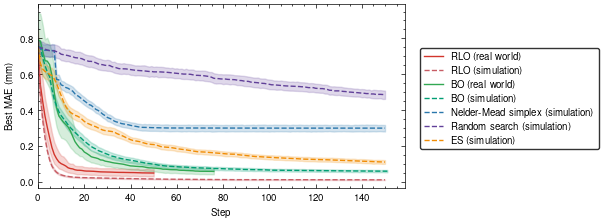

In [16]:
# Pretty combined over time plot for paper
fig, ax = plt.subplots(
    1, 1, figsize=(510 / 72.72 * 0.6, 510 / 72.72 * 0.5 * 2 / 3), sharey="row"
)
palette_colors = [
    "#D2352C",
    "#C75C64",
    "#32A852",
    "#009E73",
    "#2A77AC",
    "#614099",
    "#F18D05",
]

# Best MAE
sns.lineplot(
    data=data_series["RLO (real world)"]["best mae"],
    ax=ax,
    color=palette_colors[0],
    label="RLO (real world)",
)
sns.lineplot(
    data=data_series["RLO (simulation)"]["best mae"],
    ax=ax,
    linestyle="--",
    color=palette_colors[1],
    label="RLO (simulation)",
)
sns.lineplot(
    data=data_series["BO (real world)"]["best mae"],
    ax=ax,
    color=palette_colors[2],
    label="BO (real world)",
)
sns.lineplot(
    data=data_series["BO (simulation)"]["best mae"],
    ax=ax,
    linestyle="--",
    color=palette_colors[3],
    label="BO (simulation)",
)
sns.lineplot(
    data=data_series["Nelder-Mead simplex (simulation)"]["best mae"],
    ax=ax,
    linestyle="--",
    color=palette_colors[4],
    label="Nelder-Mead simplex (simulation)",
)
sns.lineplot(
    data=data_series["Random search (simulation)"]["best mae"],
    ax=ax,
    linestyle="--",
    color=palette_colors[5],
    label="Random search (simulation)",
)
sns.lineplot(
    data=data_series["ES (simulation)"]["best mae"],
    ax=ax,
    linestyle="--",
    color=palette_colors[6],
    label="ES (simulation)",
)

right_handles, right_labels = ax.get_legend_handles_labels()
ax.legend([])
fig.legend(
    right_handles,
    right_labels,
    ncol=1,
    frameon=True,
    edgecolor="inherit",
    loc="center left",
    bbox_to_anchor=(1.0, 0.55),
)
# ax.set_title("(b)", loc="left")
ax.set_xlim([0, None])
ax.set_xlabel("Step")
ax.set_ylabel("Best MAE (mm)")
# fig.subplots_adjust(wspace=0.05)
fig.tight_layout()
plt.savefig(f"{FIG_DIR}/best_mae_over_time_all.pdf")
